# Galaxy Classifiers (Spiral, Elliptical, Odd objects)

## 1. Base on Zernike moments:

In [ ]:
# import packages

import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (roc_curve, roc_auc_score, auc, log_loss,
                             precision_score, recall_score, f1_score,
                             accuracy_score, classification_report,
                             ConfusionMatrixDisplay, confusion_matrix)

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#Tensorflow
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import (Dense, Activation, Dropout,BatchNormalization, Input, Conv1D, Conv2D, Flatten,
                             Convolution2D, MaxPool2D, MaxPooling1D, MaxPooling2D)
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping


#Scikit_learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, auc, log_loss,
                             precision_score, recall_score, f1_score,
                             accuracy_score, classification_report,
                             ConfusionMatrixDisplay, confusion_matrix)
from sklearn import metrics
from sklearn.preprocessing import label_binarize

In [ ]:
# If using Google Colab.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Compute the ZMs:

##### The ZEMO python package [https://pypi.org/project/ZEMO/] [https://github.com/hmddev1/ZEMO] can be used to compute Zernike moments (Zms) for your images. This library is described in a research paper you can find online [[arxiv:2308.13562](https://arxiv.org/abs/2308.13562v2)].

In [ ]:
from ZEMO import zemo
import os
import cv2

image_size = 200
zernike_order = 45

ZBFSTR = zemo.zernike_bf(image_size, zernike_order, 1)    

- To use our image data use these directories from the repo.:
        
        - Spiral: 
        - Elliptical:
        - Odd objects: 

In [ ]:
path = r'/path/to/your/directory/galaxy' 

image_files = [os.path.join(path, filename) for filename in os.listdir(path) if filename.endswith('.jpg')]
len(image_files)

In [ ]:
ZZ = []

for img_path in image_files:
    image = cv2.imread(img_path)
    resized_image = cv2.resize(image, (image_size, image_size))
    im = resized_image[:,:,0]
    Z = np.abs(zemo.zernike_mom(np.array(im), ZBFSTR))
    ZZ.append(Z)


# Save the ZMs as data frame
df = pd.DataFrame(ZZ)
df.to_csv('/path/to/your/directory/spiral_zms.csv')

- To use our Zernike moment features data set, use these directories from the repo.:
        
        - Spiral: 
        - Elliptical:
        - Odd objects:

In [ ]:
spiral_data = pd.read_csv('/path/to/your/directory/spiral_zms.csv')
elliptical_data = pd.read_csv('/path/to/your/directory/elliptical_zms.csv')
odd_data = pd.read_csv('/path/to/your/directory/odd_zms.csv')

spiral_data.drop("Unnamed: 0", axis = 1, inplace = True)
elliptical_data.drop("Unnamed: 0", axis = 1, inplace = True)
odd_data.drop("Unnamed: 0", axis = 1, inplace = True)

all_zm_data = np.concatenate([spiral_data, elliptical_data, odd_data])
np.shape(all_zm_data)

In [ ]:
# Labels

num_class = 3
spiral_label = [0] * len(spiral_data)
elliptical_label = [1] * len(elliptical_data)
odd_label = [2] * len(odd_data)
all_labels = np.concatenate([spiral_label, elliptical_label, odd_label])
len(all_labels)

#### Check the class weights:


In [ ]:
total_samples = len(all_zm_data)
class_weights = {
    0: total_samples / (3*len(spiral_data)),  # Class 0 (or Class 1) weight
    1: total_samples / (3*len(elliptical_data)),   # Class 1 (or Class 2) weight
    2: total_samples / (3*len(odd_data))    # Class 2 (or Class 3) weight
}

print("Class Weights based on Inverse Class Frequency:")
print("Class 1 Weight:", class_weights[0])
print("Class 2 Weight:", class_weights[1])
print("Class 3 Weight:", class_weights[2])


#### Fit the SVM model for 10 iterations and calculate the standard deviation.
##### (You can save the performance materials and the models outputs.) 

In [ ]:
y_test_list = []
models = []
Y_pred = []
accs = []
cons = []
aucs = []
fprs = []
tprs = []
test_indx=[]


for i in range(10):
    X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(all_zm_data, all_labels, np.arange(len(all_labels)), test_size=0.25, shuffle=True, random_state=None)
    y_test_list.append(y_test)
    test_indx.append(test_indices)

    class_weights = {0: len(all_zm_data) / (3*len(spiral_data)), 1: len(all_zm_data) / (3*len(elliptical_data)), 2: len(all_zm_data) / (3*len(odd_data))}

    model = SVC(kernel='rbf', probability=True, C=1.5, gamma='scale',class_weight=class_weights)
    gz2_training_model = model.fit(X_train, y_train)
    models.append(gz2_training_model)

    y_score = gz2_training_model.predict_proba(X_test)  # Use predicted probabilities for ROC vurve
    y_test_bin = label_binarize(y_test, classes=list(range(3)))  # Binarize the true labels

    y_pred = gz2_training_model.predict(X_test)
    Y_pred.append(y_pred)

    con0 = metrics.confusion_matrix(y_test, y_pred)
    cons.append(con0)

    acc = metrics.accuracy_score(y_test, y_pred)
    accs.append(acc)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)

In [ ]:
print(np.mean(accs), np.std(accs))

# Calculate mean of all AUC values
all_auc_values = [auc_value for auc_dict in aucs for auc_value in auc_dict.values()]
mean_auc = np.mean(all_auc_values)
std_auc = np.std(all_auc_values)

print("Mean of all AUC values:", mean_auc)
print("Standard Deviation of all AUC values:", std_auc)


0.9050443081117928 0.003266298173336322
Mean of all AUC values: 0.9770435503194648
Standard Deviation of all AUC values: 0.020048188703497838


In [ ]:
output_path = '/path/to/your/directory'
import os
pickle_filename = 'tprs_svm_zms_galaxy_classifier.pickle'
pickle_filepath = os.path.join(output_path, pickle_filename)

with open(pickle_filepath, 'wb') as pickle_file:
    pickle.dump(tprs, pickle_file)


#### Fit the 1D-CNN model for 10 iterations and calculate the standard deviation.
##### (You can save the performance materials and the models outputs.) 

In [ ]:
from math import e

y_test_list = []
models = []
Y_pred = []
accs = []
cons = []
aucs = []
fprs = []
tprs = []
test_indx=[]

b_size = 64
e_num = 30

for i in range (10):
    X_train, X_test, y_train, y_test = train_test_split(all_zm_data, all_labels, test_size=0.25, shuffle=True, random_state=None)
    y_test_list.append(y_test)
    test_indx.append(test_indices)

    class_weights = {0: len(all_zm_data) / (3*len(spiral_data)), 1: len(all_zm_data) / (3*len(elliptical_data)), 2: len(all_zm_data) / (3*len(odd_data))}
    y_train_encoded = to_categorical(y_train, num_classes=3)

    # input
    x = Input(shape=(all_zm_data.shape[1],1))

    #hidden layers
    c0 = Conv1D(256, kernel_size=3, strides=2, padding="same")(x)
    b0 = BatchNormalization()(c0)
    m0 = MaxPooling1D(pool_size=2)(b0)
    d0 = Dropout(0.1)(m0)

    c1 = Conv1D(128, kernel_size=3, strides=2, padding="same")(d0)
    b1 = BatchNormalization()(c1)
    m1 = MaxPooling1D(pool_size=2)(b1)
    d1 = Dropout(0.1)(m1)

    c2 = Conv1D(64, kernel_size=3, strides=2, padding="same")(d1)
    b2 = BatchNormalization()(c2)
    m2 = MaxPooling1D(pool_size=2)(b2)
    d2 = Dropout(0.1)(m2)

    f = Flatten()(d2)

    de0 = Dense(64, activation='relu')(f)
    de1 = Dense(32, activation='relu')(de0)
    de2 = Dense(3, activation='softmax')(de1)

    model = Model(inputs=x, outputs=de2, name="cnn_zm_45_galaxy_classifier")
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    # Callback Functions
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

    history = model.fit(
    X_train, y_train_encoded,
    batch_size=b_size,
    epochs=e_num,
    class_weight=class_weights,
    verbose = 1,
    callbacks=es,
    validation_split=0.1
    )
    models.append(history)

    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    Y_pred.append(y_pred_labels)

    y_test_bin = label_binarize(y_test, classes=list(range(3)))  # Binarize the true labels

    con0 = metrics.confusion_matrix(y_test, y_pred_labels)
    cons.append(con0)

    acc = metrics.accuracy_score(y_test, y_pred_labels)
    accs.append(acc)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)

## 2. Base on original images 
- (Vision Transformers used as data augmentation tools on the Galaxy and Non-Galaxy images.)

In [ ]:
# import packages 

import cv2
import os
import numpy as np
import random
from PIL import Image
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

#Tensorflow
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Input,Conv2D, Flatten,
                             MaxPooling2D,BatchNormalization)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, VGG16
from keras.callbacks import EarlyStopping

#Torch
import torch
import torch.nn as nn
from torchvision import transforms

### The load_galaxy_images functions uses for read and pre-process the input images

In [ ]:
def load_galaxy_images(data_dir, target_size):
        
        """
        Loads, resizes, and processes all JPG images from the specified directory.

        Parameters:
        data_dir (str): The directory containing the JPG images to be processed.
        target_size (tuple): The target size for resizing the images, specified as (width, height).

        Returns:
        list: A list of PIL Image objects, each representing a resized and processed image.

        The function performs the following steps:
        1. Lists all JPG image files in the specified directory.
        2. Reads each image using OpenCV.
        3. Resizes each image to the specified target size.
        4. Scales the pixel values and converts the image to a format compatible with PIL.
        5. Converts each resized image to a PIL Image object.
        6. Appends each PIL Image object to a list.
        7. Returns the list of PIL Image objects.
        """

        all_images = []

        file_path = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) if filename.endswith('.jpg')]

        for img in file_path:
            image = cv2.imread(img)
            resized_images=cv2.resize(image, target_size)
            resized_images = (resized_images * 255).astype(np.uint8)
            pil_images = Image.fromarray(resized_images)
            all_images.append(pil_images)

        return all_images

- To use our image data use these directories from the repo.:
        
        - Spiral: 
        - Elliptical:
        - Odd objects: 

In [ ]:
el_dir = '/content/drive/MyDrive/Data/GZ2_E_S_I/new/crop/elliptical'
sp_dir = '/content/drive/MyDrive/Data/GZ2_E_S_I/new/crop/spiral'
odd_dir = '/content/drive/MyDrive/Data/GZ2_E_S_I/new/crop/odd'

image_size = 200

sp_img = load_galaxy_images(sp_dir, target_size=(image_size,image_size))
el_img = load_galaxy_images(el_dir, target_size=(image_size,image_size))
odd_img = load_galaxy_images(odd_dir, target_size=(image_size,image_size))

all_data = np.concatenate([sp_img, el_img, odd_img])
np.shape(all_data)

### vision transformer

In [ ]:
# transforms for training data
train_transform = transforms.Compose([transforms.CenterCrop(image_size),
                                      transforms.RandomRotation(90),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0), ratio=(0.99, 1.01)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])


# transforms for test data
test_transform = transforms.Compose([transforms.CenterCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

In [ ]:
num_classes = 3

label_s = [0] * len(sp_img)
label_e = [1] * len(el_img)
label_o = [2] * len(odd_img)
all_labels = np.concatenate([label_s, label_e, label_o])
len(all_labels)

In [ ]:
b_size =64
e_num = 30

X_list=[]
y_list=[]
models=[]
Y_pred=[]
accs=[]
cons=[]
aucs=[]
fprs=[]
tprs=[]

for i in range (10):
    X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.25, shuffle=True, random_state=None)
    X_list.append(X_train)
    y_list.append(y_train)

    class_weights = {0: len(all_data) / (3*len(sp_img)), 1: len(all_data) / (3*len(el_img)), 2: len(all_data) / (3*len(ir_img))}
    y_train_encoded = to_categorical(y_train, num_classes=3)

    # Training data
    transformed_X_train=[]
    for i in range(len(X_train)):
      transformed_train_images = train_transform(X_train[i])
      new_image = np.transpose(transformed_train_images, (1, 2, 0))
      transformed_X_train.append(new_image)

    # Testing data
    transformed_X_test=[]
    for j in range(len(X_test)):
      transformed_test_images = test_transform(X_test[j])
      new_images = np.transpose(transformed_test_images, (1, 2, 0))
      transformed_X_test.append(new_images)

    # input
    x = Input(shape=(image_size,image_size,3))

    #hidden layers
    c0 = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding="same")(x)
    b0 = BatchNormalization()(c0)
    m0 = MaxPooling2D(pool_size=(2, 2))(b0)
    d0 = Dropout(0.1)(m0)

    c1 = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding="same")(m0)
    b1 = BatchNormalization()(c1)
    m1 = MaxPooling2D(pool_size=(2, 2))(b1)
    d1 = Dropout(0.1)(m1)

    c2 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")(m1)
    b2 = BatchNormalization()(c2)
    m2 = MaxPooling2D(pool_size=(2, 2))(b2)
    d2 = Dropout(0.1)(m2)

    f = Flatten()(m2)

    de0 = Dense(64, activation='relu')(f)
    de1 = Dense(32, activation='relu')(de0)
    de2 = Dense(3, activation='softmax')(de1)

    model = Model(inputs=x, outputs=de2, name="cnn_transformer_galaxy_nonegalaxy")
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    # Callback Functions
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

    history = model.fit(
    np.array(transformed_X_train), y_train_encoded,
    batch_size=b_size,
    epochs=e_num,
    verbose = 1,
    class_weight=class_weights,
    callbacks=es,
    validation_split=0.1
    )
    models.append(history)

    y_pred = model.predict(np.array(transformed_X_test))
    y_pred_labels = np.argmax(y_pred, axis=1)
    Y_pred.append(y_pred_labels)

    con0 = metrics.confusion_matrix(y_test, y_pred_labels)
    cons.append(con0)

    acc = metrics.accuracy_score(y_test, y_pred_labels)
    accs.append(acc)

    y_test_bin = label_binarize(y_test, classes=list(range(3)))  # Binarize the true labels

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)

In [ ]:
b_size =64
e_num = 30

X_list=[]
y_list=[]
models=[]
Y_pred=[]
accs=[]
cons=[]
aucs=[]
fprs=[]
tprs=[]

for i in range (10):
    X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.25, shuffle=True, random_state=None)
    X_list.append(X_train)
    y_list.append(y_train)

    class_weights = {0: len(all_data) / (3*len(sp_img)), 1: len(all_data) / (3*len(el_img)), 2: len(all_data) / (3*len(ir_img))}
    y_train_encoded = to_categorical(y_train, num_classes=3)

    # Training data
    transformed_X_train=[]
    for i in range(len(X_train)):
      transformed_train_images = train_transform(X_train[i])
      new_image = np.transpose(transformed_train_images, (1, 2, 0))
      transformed_X_train.append(new_image)

    # Testing data
    transformed_X_test=[]
    for j in range(len(X_test)):
      transformed_test_images = test_transform(X_test[j])
      new_images = np.transpose(transformed_test_images, (1, 2, 0))
      transformed_X_test.append(new_images)

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    x = Flatten()(base_model.output)
    x = Dense(64, activation='relu')(x)  # Add your custom layers here
    output = Dense(3, activation='softmax')(x)  # 3 classes, so 3 output units with softmax activation

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Callback Functions
    es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

    history = model.fit(
    np.array(transformed_X_train), y_train_encoded,
    batch_size=b_size,
    epochs=e_num,
    verbose = 1,
    callbacks=es,
    class_weight= class_weights,
    validation_split=0.1
    )
    models.append(history)

    y_score = model.predict(np.array(transformed_X_test))  # Use predicted probabilities
    y_pred_labels = np.argmax(y_score, axis=1)
    Y_pred.append(y_pred_labels)

    con0 = metrics.confusion_matrix(y_test, y_pred_labels)
    cons.append(con0)

    acc = metrics.accuracy_score(y_test, y_pred_labels)
    accs.append(acc)

    y_test_bin = label_binarize(y_test, classes=list(range(3)))  # Binarize the true labels

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)

In [ ]:
b_size =64
e_num = 30

X_list=[]
y_list=[]
models=[]
Y_pred=[]
accs=[]
cons=[]
aucs=[]
fprs=[]
tprs=[]

for i in range (10):
    X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.25, shuffle=True, random_state=None)
    X_list.append(X_train)
    y_list.append(y_train)

    class_weights = {0: len(all_data) / (3*len(sp_img)), 1: len(all_data) / (3*len(el_img)), 2: len(all_data) / (3*len(ir_img))}
    y_train_encoded = to_categorical(y_train, num_classes=3)

    # Training data
    transformed_X_train=[]
    for i in range(len(X_train)):
      transformed_train_images = train_transform(X_train[i])
      new_image = np.transpose(transformed_train_images, (1, 2, 0))
      transformed_X_train.append(new_image)

    # Testing data
    transformed_X_test=[]
    for j in range(len(X_test)):
      transformed_test_images = test_transform(X_test[j])
      new_images = np.transpose(transformed_test_images, (1, 2, 0))
      transformed_X_test.append(new_images)

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))


    x = Flatten()(base_model.output)
    x = Dense(64, activation='relu')(x)
    output = Dense(3, activation='softmax')(x)  # 3 classes, so 3 output units with softmax activation

    # Create a new model with modified top layers
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Callback Functions
    es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

    history = model.fit(
    np.array(transformed_X_train), y_train_encoded,
    batch_size=b_size,
    epochs=e_num,
    verbose = 1,
    callbacks=es,
    class_weight=class_weights,
    validation_split=0.1
    )
    models.append(history)

    y_score = model.predict(np.array(transformed_X_test))  # Use predicted probabilities
    y_pred_labels = np.argmax(y_score, axis=1)
    Y_pred.append(y_pred_labels)

    con0 = metrics.confusion_matrix(y_test, y_pred_labels)
    cons.append(con0)

    acc = metrics.accuracy_score(y_test, y_pred_labels)
    accs.append(acc)

    y_test_bin = label_binarize(y_test, classes=list(range(3)))  # Binarize the true labels

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)

#### ROC curve

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Data/GZ2_E_S_I/new/performance_materials/fprs_cnn_zms_galaxy_classifier.pickle'

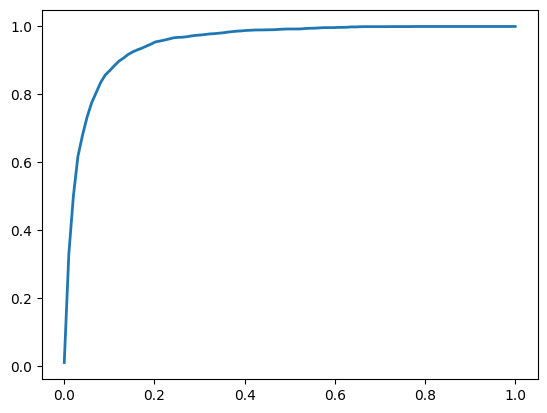

In [ ]:
from matplotlib import font_manager

font_path = '/content/drive/MyDrive/Data/star_galaxy/TIMES.TTF'

classifier_names = ['svm_zms', 'cnn_zms', 'cnn_transformer', 'resnet_transformer', 'vgg_transformer']

for classifier_name in classifier_names:
    with open(f'/content/drive/MyDrive/Data/GZ2_E_S_I/new/performance_materials/fprs_{classifier_name}_galaxy_classifier.pickle', 'rb') as f:
        fprs = pickle.load(f)
    with open(f'/content/drive/MyDrive/Data/GZ2_E_S_I/new/performance_materials/tprs_{classifier_name}_galaxy_classifier.pickle', 'rb') as f:
        tprs = pickle.load(f)

    mean_fpr = np.linspace(0, 1, 100)
    tprs_interp = []

    for i in range(len(fprs)):
        tprs_interp.append(np.interp(mean_fpr, fprs[i][2], tprs[i][2]))

    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, label=f'{classifier_name} (area = {mean_auc:.2f})', lw=2)

if font_manager.FontProperties(fname=font_path).get_name() != 'Custom':
    font = font_manager.FontProperties(fname=font_path)

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')
plt.xlabel('False Positive Rate', fontproperties=font)
plt.ylabel('True Positive Rate', fontproperties=font)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontproperties=font)
plt.legend(loc='lower right', prop=font_manager.FontProperties(fname=font_path))
plt.savefig("/content/drive/MyDrive/Data/GZ2_E_S_I/figs/ROC_galaxy_classifier_irregular.eps", format="eps")
plt.show()
